In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#build vocabulaty of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
#build the dataset
block_size = 3 #context length: how many characters to look at to predict the next one?

def build_dataset(words):
    X,Y = [],[]
    for w in words: #all words
        
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop the first element and apend the new one

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1  = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])            #80%
Xdev, Ydev = build_dataset(words[n1:n2])        #10%
Xte, Yte = build_dataset(words[n2:])            #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
#MLP Revisited
n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) #for reproducibility
C = torch.randn((vocab_size,n_embd), generator=g) #embedding layer

W1 = torch.randn((block_size*n_embd,200), generator=g) #first layer
b1 = torch.randn(n_hidden, generator=g) #biases for first layer

W2 = torch.randn((n_hidden,vocab_size), generator=g) #second layer
b2 = torch.randn(vocab_size, generator=g) #biases for second layer

parameters = [C, W1, b1, W2, b2] #all the parameters

for p in parameters:
    p.requires_grad = True #enabling gradients for all parameters

print(sum(p.nelement() for p in parameters)) #total no. of parameters

11897


In [6]:
stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

print('Training Loss:', loss.item())

      0/  20000: 27.8817
   1000/  20000: 4.0763
   2000/  20000: 3.0432
   3000/  20000: 2.9293
   4000/  20000: 2.3651
   5000/  20000: 2.3953
   6000/  20000: 2.3735
   7000/  20000: 2.8519
   8000/  20000: 2.4473
   9000/  20000: 2.5038
  10000/  20000: 2.8465
  11000/  20000: 2.0805
  12000/  20000: 2.4704
  13000/  20000: 2.4806
  14000/  20000: 2.9589
  15000/  20000: 2.2172
  16000/  20000: 2.5939
  17000/  20000: 2.6985
  18000/  20000: 2.4330
  19000/  20000: 2.3111
Training Loss: 2.054908275604248


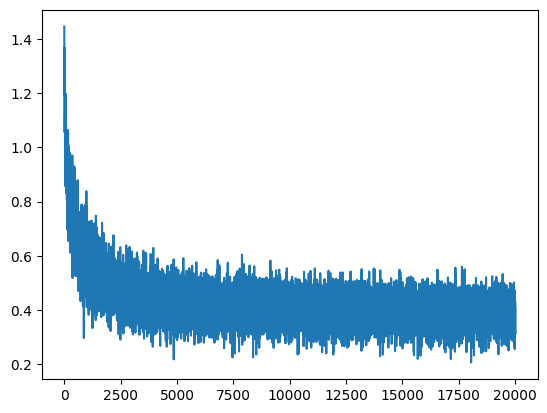

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() #this decorator disables gradient tracking
                 #whatever happens in this function below, it instructs pytorch
                 #to never require gradients for these operations since pytorch usually keeps track of gradients in anticipation of a backward pass
                 #but yaha koi backward pass nahi hai!
                 #for efficiency
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('val')

train loss: 2.4800
val loss: 2.4986


In [9]:
#Sample form the model
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size #initialise with all '...'
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,d): 1st dim was the size of training set, but here we're generating only 1 example,
        h = torch.tanh(emb.view(1,-1)@W1+b1)
        logits = h@W2 +b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:]+[ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word


arrachmyah.
keel.
nah.
yal.
azthancendra.
galie.
adrelin.
aly.
jenre.
annean.
aar.
kayzish.
karin.
sadger.
ahimies.
kandreelle.
anthora.
uza.
aveer.
yarre.


In [11]:
#Deeper look at the code
#Initial loss, at 0th iteration is very high, Network is very confidently wrong .'. high initiall loss
# idially it must be low
#and we can have an idea of the loss to expect at the beginnning
#by thinking that at the start, the probab distrib of all of the characters 
#must be a uniform distribution, since we have no reason to think about why 
#some characters must be higher than others
-torch.tensor(1/27.0).log() #-log liklih of uniform distribution



tensor(3.2958)

In [ ]:
#4D example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[1].log() #checking the probab of the 2nd character (assuming it to be next character)
print(probs, loss )
#But, if the probs are like uniform distribution (i.e. if all/most logits are near to 0)
#then it doesnt matter we check the loss for the 2nd character or 3rd or 4th etc..
#because all of them will have the same loss

#PURELY by chance it can happen that say 2nd character got high logit, 
#i.e. high probab
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
#then checking loss of 2nd chracter will give very very loww loss
#and even though this is good for us, but this could be a local minima
loss = -probs[1].log() 
print(probs, loss )

#But most of the times other characters will have high logits (fake counts)
#i.e. high probab to wrong other characters which will give us high loss
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) #these are near to 0
probs = F.softmax(logits, dim=0)
loss = -probs[1].log() #checking the probab of the 2nd character (assuming it to be next character)
print(logits, probs, loss)

logits = torch.randn(4) *10 #but if we make the logits high, then the prob will also be high, chances of 'wrong' probs being high also increases -> and hence our loss increases
probs = F.softmax(logits, dim=0)
loss = -probs[1].log() #checking the probab of the 2nd character (assuming it to be next character)
print(logits, probs, loss )

#similarly, if our logits are even more extreme, then we'll get higher probabs, i.e. higher chance of getting 'wrong' probs high -> i.e. even high loss
#so, we need some kind of normalisation of logits
#to make the loss independent of the scale of logits


tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
tensor([0.0066, 0.9802, 0.0066, 0.0066]) tensor(0.0200)
tensor([-0.4403,  0.6508, -0.2400,  0.3649]) tensor([0.1345, 0.4004, 0.1643, 0.3008]) tensor(0.9153)
tensor([ 4.7755, -1.6245, 10.0559,  4.4860]) tensor([5.0454e-03, 8.3833e-06, 9.9117e-01, 3.7771e-03]) tensor(11.6893)


In [ ]:
#Let us re run the model training, and lets stop the model after 1st iteration

stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    break

print('Training Loss:', loss.item())

      0/  20000: 27.8817
Training Loss: 27.881732940673828


In [ ]:
#such a high initall loss is because the logits are taking extrem values
logits[0] #lets see first row of logits
#so, we need logits to be nearer to 0, i.e. less extreme

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [ ]:
#So, we modify our nextwork:

#MLP Revisited
n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) 
b1 = torch.randn(n_hidden, generator=g)  
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0.01 #scale down W2 to make the logits closer to 0
b2 = torch.randn(vocab_size, generator=g)  *0 #we want b2 to be 0 initially, since we want logits to be nearer to 0 (or apas me pass)

parameters = [C, W1, b1, W2, b2] #all the parameters

for p in parameters:
    p.requires_grad = True #enabling gradients for all parameters

print(sum(p.nelement() for p in parameters)) #total no. of parameters

11897


In [ ]:
#Let us re run the model training, and lets stop the model after 1st iteration

stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    

print('Training Loss:', loss.item())
#initially loss is much less now
#we can scale down W2 even lower to get even smaller loss
#let us run it for more iterations

      0/  20000: 3.3221
   1000/  20000: 2.0833
   2000/  20000: 2.3735
   3000/  20000: 2.2160
   4000/  20000: 2.3154
   5000/  20000: 2.3121
   6000/  20000: 2.2268
   7000/  20000: 2.3368
   8000/  20000: 1.9117
   9000/  20000: 2.1829
  10000/  20000: 2.1900
  11000/  20000: 1.9048
  12000/  20000: 2.3158
  13000/  20000: 2.2492
  14000/  20000: 2.7875
  15000/  20000: 2.0552
  16000/  20000: 2.4447
  17000/  20000: 2.2630
  18000/  20000: 1.9778
  19000/  20000: 2.4615
Training Loss: 1.7331013679504395


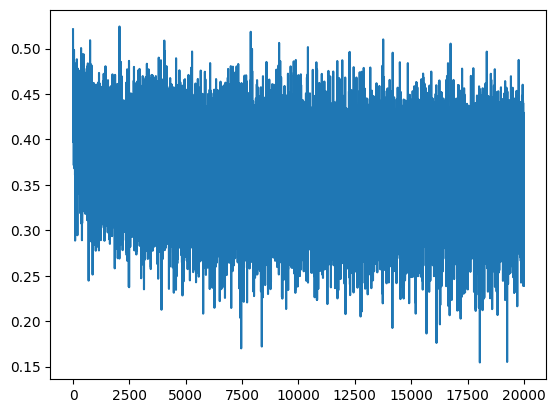

In [ ]:
plt.plot(lossi)

In [ ]:
#We dont get that 'Hockey' shape of the loss curve.
#becuase networks first try to 'squash' the logits into a uniform distribution
#and then try to rearrange the logits to the distribution of the training data
#But here, we did that initial 'easy gains' part ourselves so that our model can focus on hard gains

In [ ]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('val')

train loss: 2.2784
val loss: 2.3086


In [ ]:
#But, can we keep the weights of W2 as 0?

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) 
b1 = torch.randn(n_hidden, generator=g)  
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0 #w2 = 0
b2 = torch.randn(vocab_size, generator=g)  *0 

parameters = [C, W1, b1, W2, b2] 

for p in parameters:
    p.requires_grad = True 

print(sum(p.nelement() for p in parameters)) 

<h1>Problem 2 with our network</h1>
Tanh is too saturated

In [12]:
#So, we modify our nextwork:

#MLP Revisited
n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) 
b1 = torch.randn(n_hidden, generator=g)  
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0.01 
b2 = torch.randn(vocab_size, generator=g)  *0 

parameters = [C, W1, b1, W2, b2] 

for p in parameters:
    p.requires_grad = True 

print(sum(p.nelement() for p in parameters)) 

11897


In [13]:
#Let us re run the model training, and lets stop the model after 1st iteration

stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    break

print('Training Loss:', loss.item())


      0/  20000: 3.3221
Training Loss: 3.322058916091919


(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

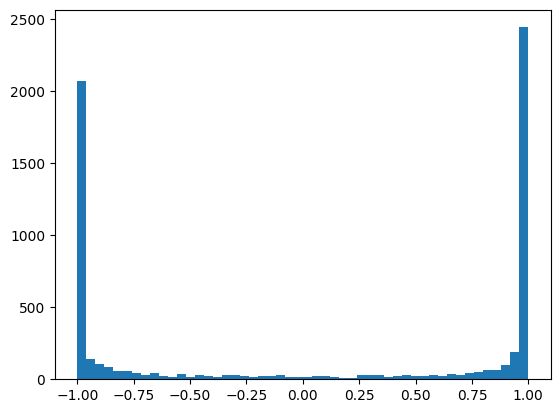

In [ ]:
h
#h is the output of the a tanh activation function
#it looks like many valus in h are 1 or -1, i.e. they seem to be saturated around 1 or -1
plt.hist(h.view(-1).tolist(), bins=50)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

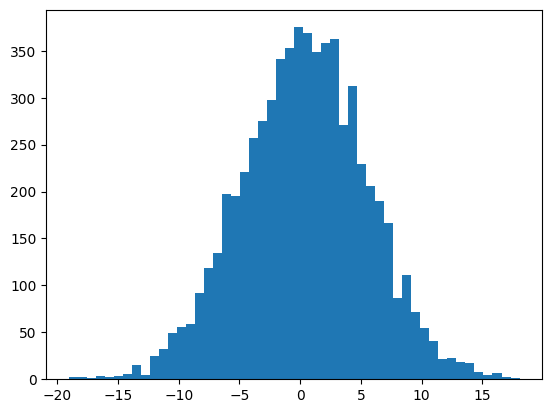

In [ ]:
#but if we see preactivations, just before entering tanh,
plt.hist(hpreact.view(-1).tolist(), bins=50)

In [ ]:
#This saturation of tanh is a big concern!
#but during the backprog of loss, 
# when we backpropagate through tanh
# we accumualate gradiants like:
# self.grad += (1 - t**2)*out.grad
#'t' is the tanh(), so agar 't' 1 ya -1 hoga, to gradients to 0 ho jayenge na!
#i.e. "vanishing gradients" for so many of the neuros jo ki 1 ya -1 hue hain tanh ki wajah se


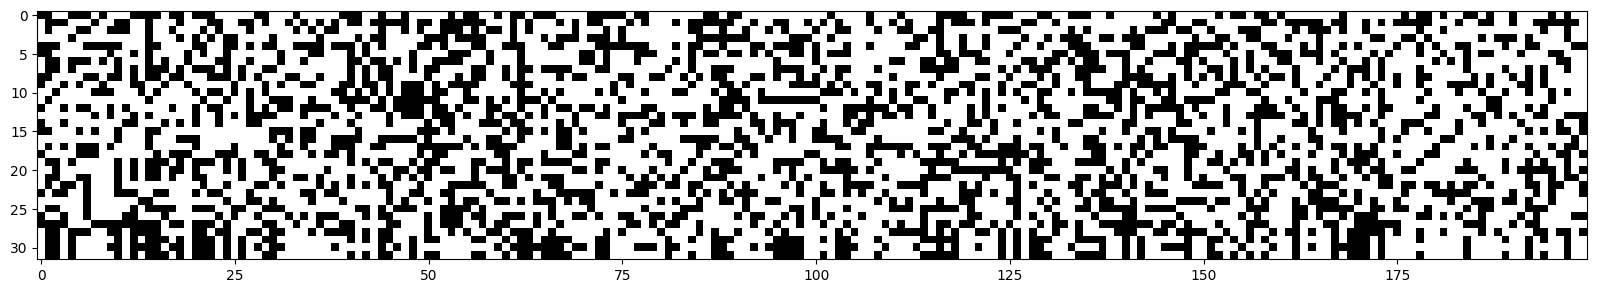

In [ ]:
#let us see how often h.abs() is above 0.99
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() >0.99, cmap='gray', interpolation='nearest') #this is a boolean tensor
#we've: 32 (batch size) examples for rows, 200 neurons for columns
#white pixels are active neurons in the 'flat' tail region of the  tanh
#If a whole column is white, then it means, that neuron is never activated 
#by any of the 32 examples of the batch -> that is a dead neuron
#i.e., if all the examples land in the tail, that that enuron will 
#never learn, that would be a dead neuron
#but since we dont have any whole white columns, that means al of the neurons have 
#some examples able to activate them, and .'. some gradients are also passing thru them

#this is same for sigmoid also

#For relu, 
#it give 0 gradient for the -ve preactivations
#and it passes as it is, for +ve preactivations
#dead relu neuron (i.e. neuron with relu non linearity never activates)

In [ ]:
#So, since we do not have any dead neurons, we're okay
#but, our hpreact is from about -15 to +15, which is very broad, which makes 
#the tanh saturate, which makes the neurons update less frequently
#so, we want hpreact to be narrow
#So, lets also scale down the weights of W1 and b1

n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) *0.2
b1 = torch.randn(n_hidden, generator=g)    *0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0.01 
b2 = torch.randn(vocab_size, generator=g)  *0 

parameters = [C, W1, b1, W2, b2] 

for p in parameters:
    p.requires_grad = True 

print(sum(p.nelement() for p in parameters)) 

11897


In [ ]:
#Let us re run the model training, and lets stop the model after 1st iteration

stepi = []
lossi = []
max_steps = 20000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    

print('Training Loss:', loss.item())


      0/  20000: 3.3135
   1000/  20000: 2.1560
   2000/  20000: 2.3728
   3000/  20000: 2.1645
   4000/  20000: 2.1078
   5000/  20000: 2.2611
   6000/  20000: 2.1219
   7000/  20000: 2.4237
   8000/  20000: 1.9729
   9000/  20000: 2.1180
  10000/  20000: 2.1648
  11000/  20000: 1.8275
  12000/  20000: 2.1509
  13000/  20000: 2.1969
  14000/  20000: 2.5895
  15000/  20000: 1.9729
  16000/  20000: 2.3832
  17000/  20000: 2.2661
  18000/  20000: 1.9382
  19000/  20000: 2.2800
Training Loss: 1.6756219863891602


(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

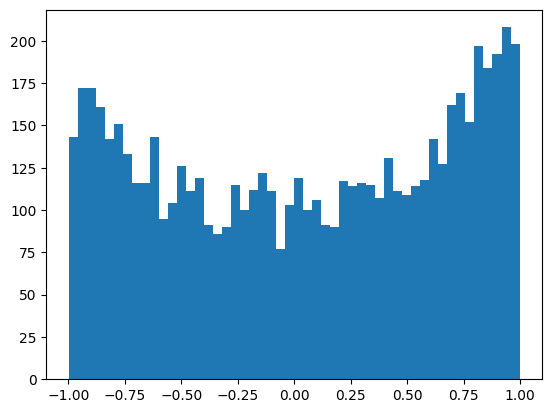

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367092, -3.62009715, -3.47652338, -3.33294961, -3.18937584,
        -3.04580207, -2.9022283 , -2.75865453, -2.61508076, -2.47150699,
        -2.32793322, -2.18435945, -2.04078568, -1.8972119 , -1.75363813,
        -1.61006436, -1.46649059, -1.32291682, -1.17934305, -1.03576928,
        -0.89219551, -0.74862174, -0.60504797, -0.4614742 , -0.31790043,
        -0.17432666, -0.03075289,  0.11282088,  0.25639465,  0.39996842,
         0.54354219,  0.68711596,  0.83068974,  0.97426351,  1.11783728,
         1.26141105,  1.40498482,  1.54855859,  1.69213236,  1.83570613,
         1.9792799 ,  2.12285367,  2.26642744,  2.41000121,  2.55357498,
 

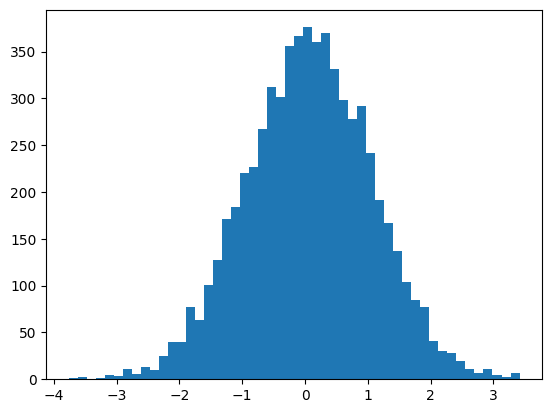

In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

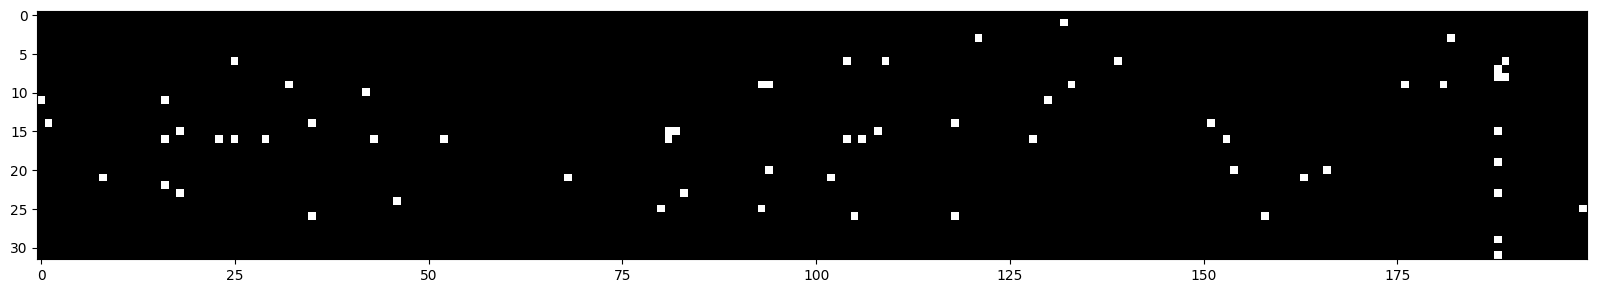

In [ ]:
#We expect most neurons to fire for most examples
#i.e. musch less whites
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() >0.99, cmap='gray', interpolation='nearest')

tensor(-0.0092) tensor(1.0005)
tensor(-0.0022) tensor(0.9981)


(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+01, 1.4000e+01, 3.2000e+01, 4.3000e+01,
        9.9000e+01, 2.0100e+02, 3.3000e+02, 6.7800e+02, 1.1510e+03,
        1.8900e+03, 3.1450e+03, 5.0380e+03, 7.5760e+03, 1.1015e+04,
        1.4609e+04, 1.8740e+04, 2.1668e+04, 2.2884e+04, 2.2196e+04,
        1.9285e+04, 1.5584e+04, 1.1695e+04, 8.2440e+03, 5.4380e+03,
        3.4140e+03, 2.0750e+03, 1.2270e+03, 7.5900e+02, 4.5100e+02,
        2.1900e+02, 1.1600e+02, 9.1000e+01, 3.5000e+01, 1.7000e+01,
        8.0000e+00, 1.1000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-6.35457802, -6.08544373, -5.81630943, -5.54717514, -5.27804085,
        -5.00890656, -4.73977226, -4.47063797, -4.20150368, -3.93236938,
        -3.66323509, -3.3941008 , -3.12496651, -2.85583221, -2.58669792,
        -2.31756363, -2.04842934, -1.77929504, -1.51016075, -1.24102646,
        -0.97189217, -0.70

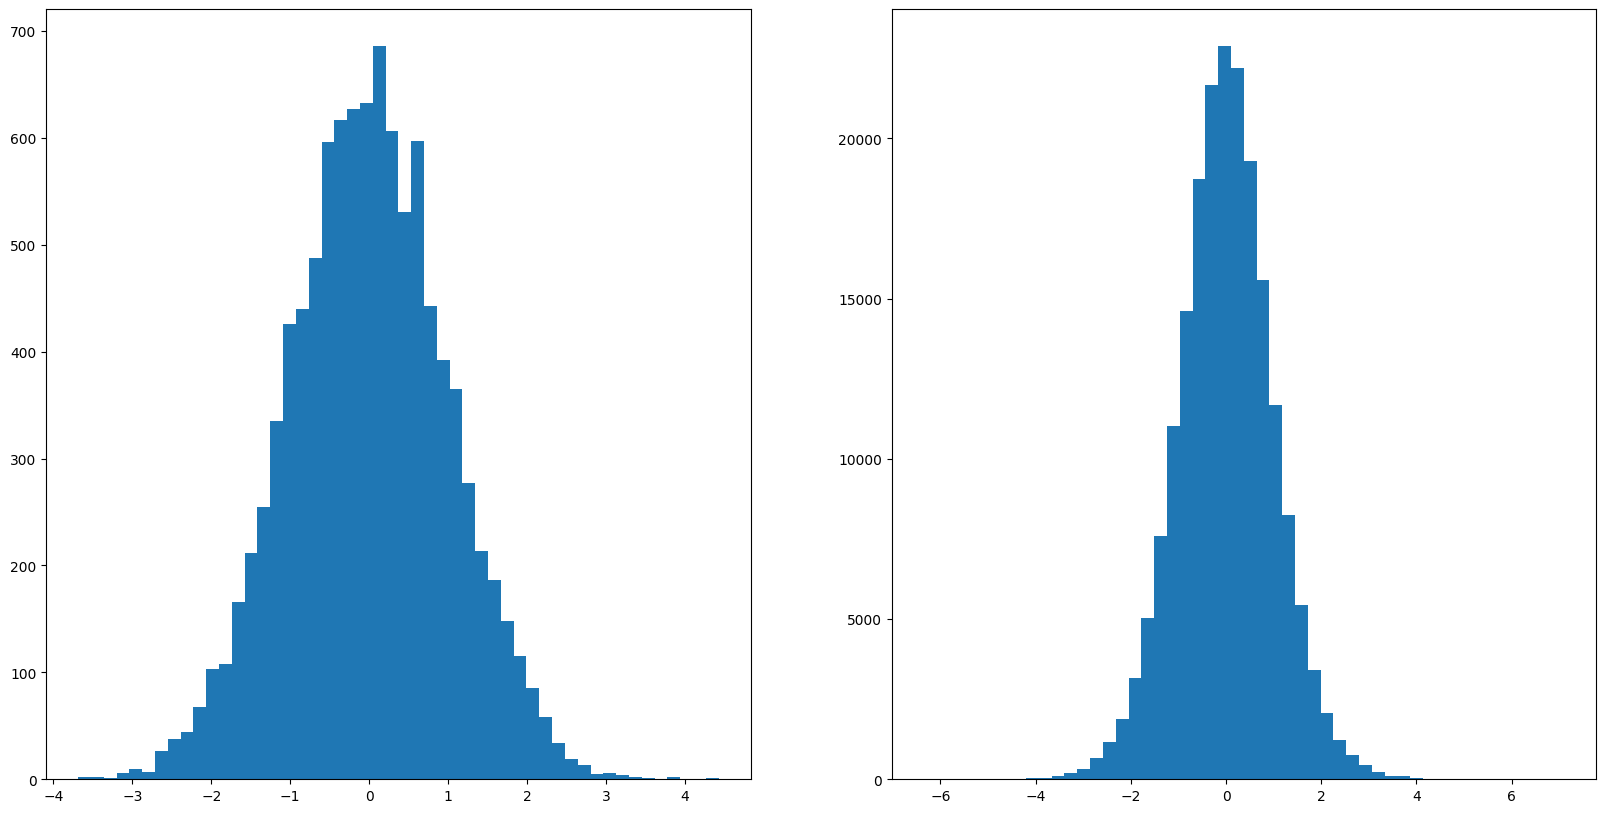

In [ ]:
#But how do we decide the scaling factor of the weight layers?
#Kaiming init
x = torch.randn(1000, 10) #1000 examples of 10 dimentional vectors
w = torch.randn(10,200) / 10**0.5 #10 inputs, 200 neurons
y = x@w #activation of 200 neurons
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50)
#We see that the stad deviation of y i.e.  x@w is much bigger than that of x
#But we want a unit std gaussian throughout the network,
#we do not want the gaussians to spread over the network
#So, how do we decide the scaling factor of the weight layers?
#So, if we divide by sqrt of the number of inputs, we get a unit std
#Std = gain/sqrt(number of inputs)


In [ ]:
(torch.randn(100000)*0.2).std() #"0.2" becomes our std deviation.
#jis bhi cheeze se gaussian ko multiply karenge, use scale karne ke liye
#wahi std dev ban jayega

tensor(0.2007)

In [ ]:
n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) *((5/3)/((block_size*n_embd)**0.5)) #*0.2
b1 = torch.randn(n_hidden, generator=g)    *0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0.01 
b2 = torch.randn(vocab_size, generator=g)  *0 

parameters = [C, W1, b1, W2, b2] 

for p in parameters:
    p.requires_grad = True 

print(sum(p.nelement() for p in parameters)) 

11897


In [ ]:
#Precise setting of the initialization is not as importatnt today because of 
#some modern innovations:
#1. Batch Normalisation
#2. Better optimizers like Adam


<h1>Batch Normalisation</h1>

In [ ]:
n_embd = 10 #dimentionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd,200), generator=g) *((5/3)/((block_size*n_embd)**0.5)) #*0.2
b1 = torch.randn(n_hidden, generator=g)    *0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) *0.01 
b2 = torch.randn(vocab_size, generator=g)  *0 

#Along with the standardisation of the preactivations (just before entering the 
#non-linearity), so that the non linearity is not saturated on the extremes, we also
#want to shift and scale the normalised preactivations. 
#Network itself learns how to 'shift and scale' the preactivations.
bngain = torch.ones((1, n_hidden)) #we multiply this in the numerator of the batch normalisation
bnbias = torch.zeros((1, n_hidden)) #we add this in the denominator of the batch normalisation
bnmean_running = torch.zeros((1, n_hidden))  #these wont be including in the 'trainig', 
bnstd_running = torch.ones((1, n_hidden))    #these are updated on the side of training

parameters = [C, W1, b1, W2, b2, bngain, bnbias] #include bngaina and bnbias '.' they'll be trainined during batch normalisation 

for p in parameters:
    p.requires_grad = True 

print(sum(p.nelement() for p in parameters)) 

12297


In [14]:
hpreact.shape

torch.Size([32, 200])

In [15]:
hpreact.mean(0, keepdim=True) #mean over all the examples in the batch
hpreact.std(0, keepdim=True)

tensor([[5.1772, 4.3557, 5.1298, 4.6331, 5.4336, 3.9707, 3.1296, 3.7061, 6.2746,
         4.3259, 4.1904, 3.8241, 3.6754, 4.0761, 2.9970, 4.0049, 6.4885, 4.0216,
         6.2354, 4.2082, 4.0197, 4.6667, 5.0524, 5.4790, 3.7729, 5.1938, 3.9100,
         4.2531, 5.9774, 5.2686, 4.4540, 4.3934, 5.5711, 5.2134, 4.9848, 4.9411,
         3.4043, 6.5647, 4.5893, 5.8455, 3.5254, 4.4762, 5.3597, 6.7694, 3.8327,
         4.0152, 4.9978, 5.1797, 2.8415, 4.0118, 3.1103, 3.0867, 4.2366, 3.1791,
         4.2943, 4.9359, 3.2233, 6.1739, 5.4840, 4.8073, 3.9314, 4.4983, 2.6390,
         4.2530, 4.9268, 4.3903, 4.5999, 3.5287, 5.5829, 6.0125, 3.6627, 4.9755,
         3.6390, 3.8517, 3.4502, 4.6531, 3.2931, 5.6221, 4.3334, 4.3870, 6.0338,
         5.0604, 5.4463, 6.1602, 4.6041, 4.4494, 3.8432, 3.4414, 3.7935, 3.9056,
         4.5801, 4.8730, 5.0217, 7.5900, 7.1101, 4.6218, 5.1139, 3.5634, 3.7085,
         4.0536, 4.0831, 4.1735, 6.2822, 3.8528, 4.7389, 5.1354, 4.6700, 4.2099,
         5.9143, 5.3890, 3.8

In [22]:
#We can simply standardise these 'pre activations'
#so they're exactly gaussian

stepi = []
lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    #BATCH NORMALISATION
    #multiplying by bngane (=1 initally) and adding bnbias (=0 initially) so that initially, the preactivations are exacly unit gaussian
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #standardise for the current batch
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    # lr = 0.1 if i<100000 else 0.01 #step lr decay
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    

print('Training Loss:', loss.item())


      0/ 200000: 3.3147
   1000/ 200000: 2.1945
   2000/ 200000: 2.3061
   3000/ 200000: 2.2337
   4000/ 200000: 2.1661
   5000/ 200000: 2.3550
   6000/ 200000: 2.1222
   7000/ 200000: 2.4549
   8000/ 200000: 2.0116
   9000/ 200000: 2.2276
  10000/ 200000: 2.1984
  11000/ 200000: 1.8837
  12000/ 200000: 2.2050
  13000/ 200000: 2.2054
  14000/ 200000: 2.6501
  15000/ 200000: 2.0817
  16000/ 200000: 2.4526
  17000/ 200000: 2.2701
  18000/ 200000: 2.0249
  19000/ 200000: 2.3733
  20000/ 200000: 2.3375
  21000/ 200000: 2.4851
  22000/ 200000: 1.9193
  23000/ 200000: 1.9813
  24000/ 200000: 2.5391
  25000/ 200000: 2.3289
  26000/ 200000: 2.3917
  27000/ 200000: 2.4123
  28000/ 200000: 2.0773
  29000/ 200000: 2.6299
  30000/ 200000: 2.4359
  31000/ 200000: 2.2457
  32000/ 200000: 2.4601
  33000/ 200000: 2.3236
  34000/ 200000: 1.9366
  35000/ 200000: 2.3067
  36000/ 200000: 2.1359
  37000/ 200000: 2.0240
  38000/ 200000: 2.6379
  39000/ 200000: 2.1167
  40000/ 200000: 2.0119
  41000/ 200000:

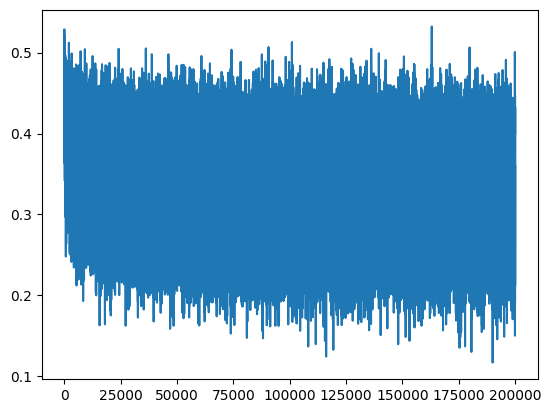

In [23]:
plt.plot(lossi)

In [ ]:
#Stability offered by batch normalisation comes at a terrible cost:
#What used to be:
# 1 example -> activations -> logits    #this is deterministic in nature
#Now, purely because of the efficiency purposes, we started using 'batches'
# 32 examples -> 32 activations -> 32 logits #these were processed independently, and it was just an efficiency thing
#But, with batch normalisation, normalisation through the batch, we are sort of, 'coupling' the 32 examples together
#So, now, when we pass through the network,
#say, 1 example, through the hpreaact layer, now hpreact is not just a function of that example and its input,
#but it's a function of all the other examples which just randmly became a batch
#So, what this does is, this creates a 'jitter' in the h, and then hpreact, and then logits (just because of the mean and std)
#But in a strange way, this turns out to be good for training. Reason is, we can think of this as a sort of 'regularisation'
#So, even if we dont like the fact that the examples in a batch normalisation are getting
#coupled in a fwd pass, we still cant do away with the batch normaliation layers
#because of a good 2nd order side effect of 'regularisation' produced by it


In [ ]:
#Now, if we want to sample from the model, or get a prediction from the model
#If we pass 1 example, the Network requires a 'mean' and a 'std' of the batch,
#i.e., the network expects a batch.. 
#So, as per the paper on batch normalisation,
#we can calculate a batch norm at the end of training, and then use that for sampling
#i.e., measure mean and std for the entire training set

with torch.no_grad(): #telling pytorch, we wont be calculating grad for this, so it will be a bit more efficient
    #pass the training set through the network
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat@W1 +b1 #get the preactivations for the entire training set
    #measure the mean and std over the entire set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    #hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #standardise for the current batch
    hpreact = bngain*(hpreact - bnmean)/bnstd + bnbias
    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('val')

In [ ]:
#Also, the thing is, nobody want to calucalte batch mean and batch std like
# bnmean = hpreact.mean(0, keepdim=True)
# bnstd = hpreact.std(0, keepdim=True) 
#So, paper also introduced a method of calc batch mean and batch std 
#in a running manner along the training of the network


In [ ]:
#We can simply standardise these 'pre activations'
#so they're exactly gaussian

stepi = []
lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) #randomly sample 32 numbers from 0 to 228146
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    embcat = emb.view(emb.shape[0], -1) #concatenate the input vectors
    hpreact = embcat@W1 +b1 #hidden layer pre-activation
    #BATCH NORMALISATION
    #multiplying by bngane (=1 initally) and adding bnbias (=0 initially) so that initially, the preactivations are exacly unit gaussian
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias #standardise for the current batch
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani #means -> 0.999*something + 0.001*secondthing -> 'mostly' be that same thing, but 0.001 times get updates in the direction of second thing
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) #first layer 
    logits = h@W2 + b2 #output of W2 layer 
    loss = F.cross_entropy(logits, Yb) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    # lr = 0.1 if i<100000 else 0.01 #step lr decay
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad #updating the parameters

    #trackstats
    if i%1000 == 0: #print evey 1000th step
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

    

print('Training Loss:', loss.item())
